In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - 1D_radial_DF_bar_transient_spiral.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Look at some of the model calculated transient winding spiral arm DFs with and
without a long slow bar.
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb, glob
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier

In [3]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Functions

## Keywords and File Names

In [12]:
tws_filenames = glob.glob('/Users/JamesLane/Desktop/transient_winding_spiral_df/2020-01-28/*.npy')
tws_bar_filenames = glob.glob('/Users/JamesLane/Desktop/transient_winding_spiral_lsbar_df/2020-02-03/*.npy')
n_files = len(tws_filenames)
assert n_files == len(tws_bar_filenames)

labels = ['TWS','TWS+LSBAR']

In [10]:
test_df_data = np.load(tws_filenames[0])
R_range = np.sort( np.unique(test_df_data[:,0]).astype(float) )
n_R = len(R_range)

# Plot tangential velocity

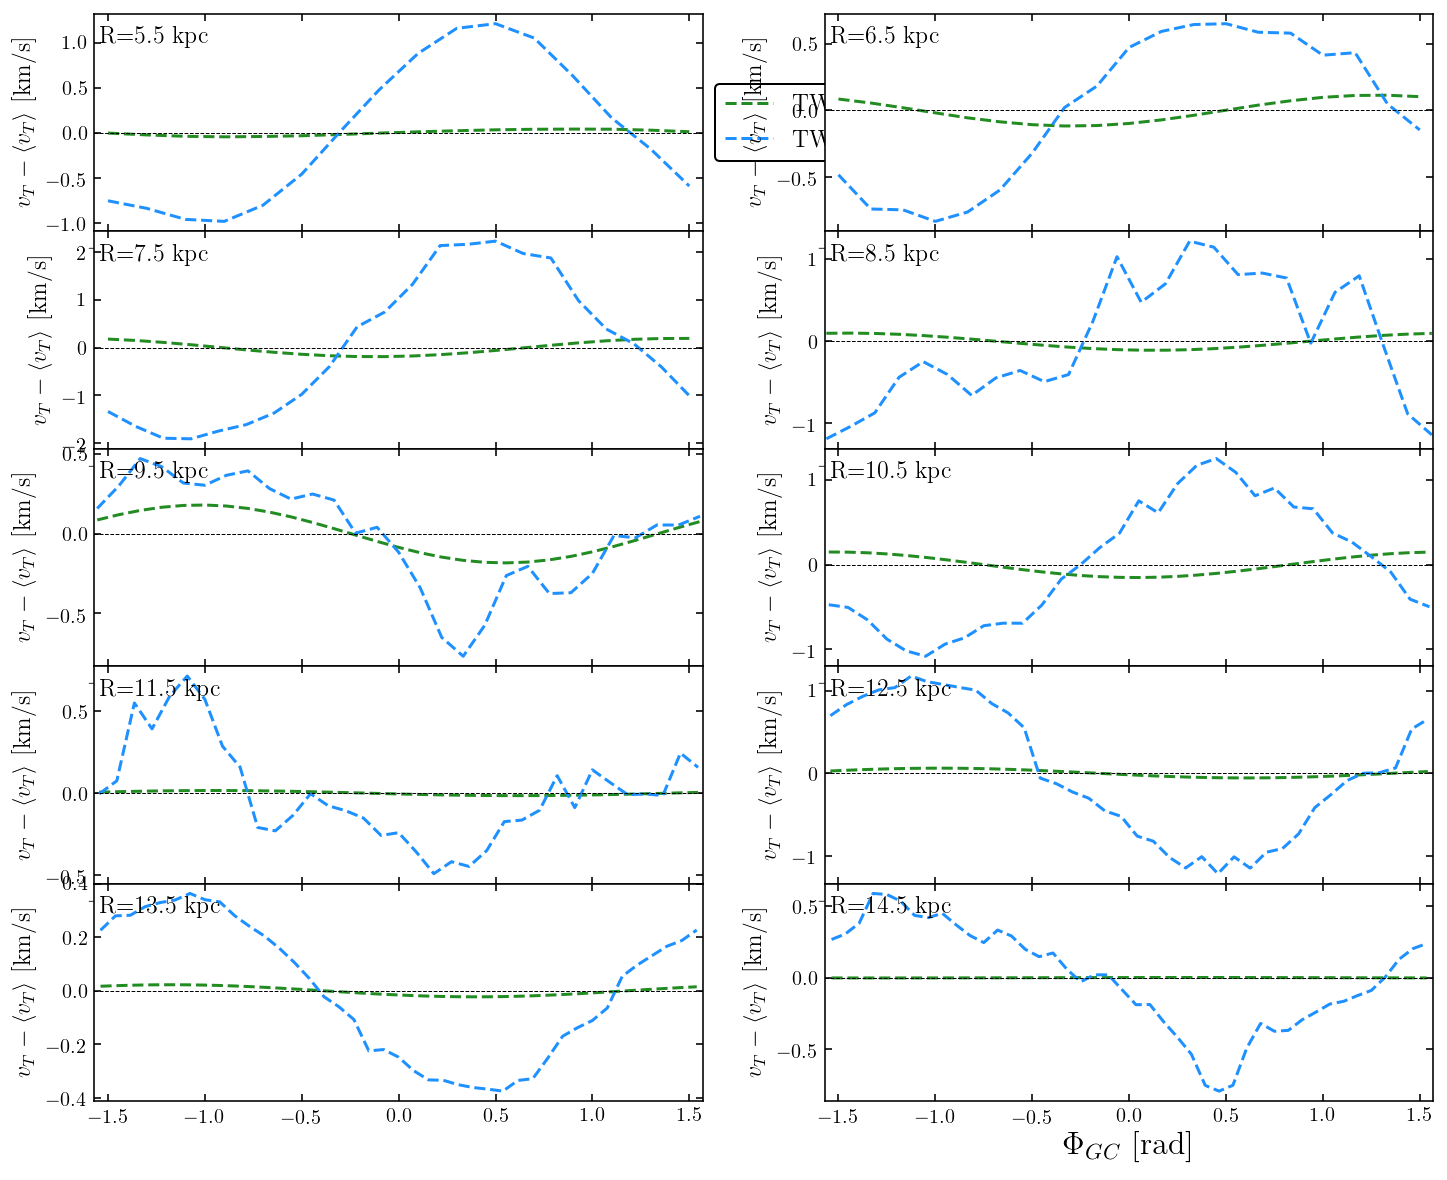

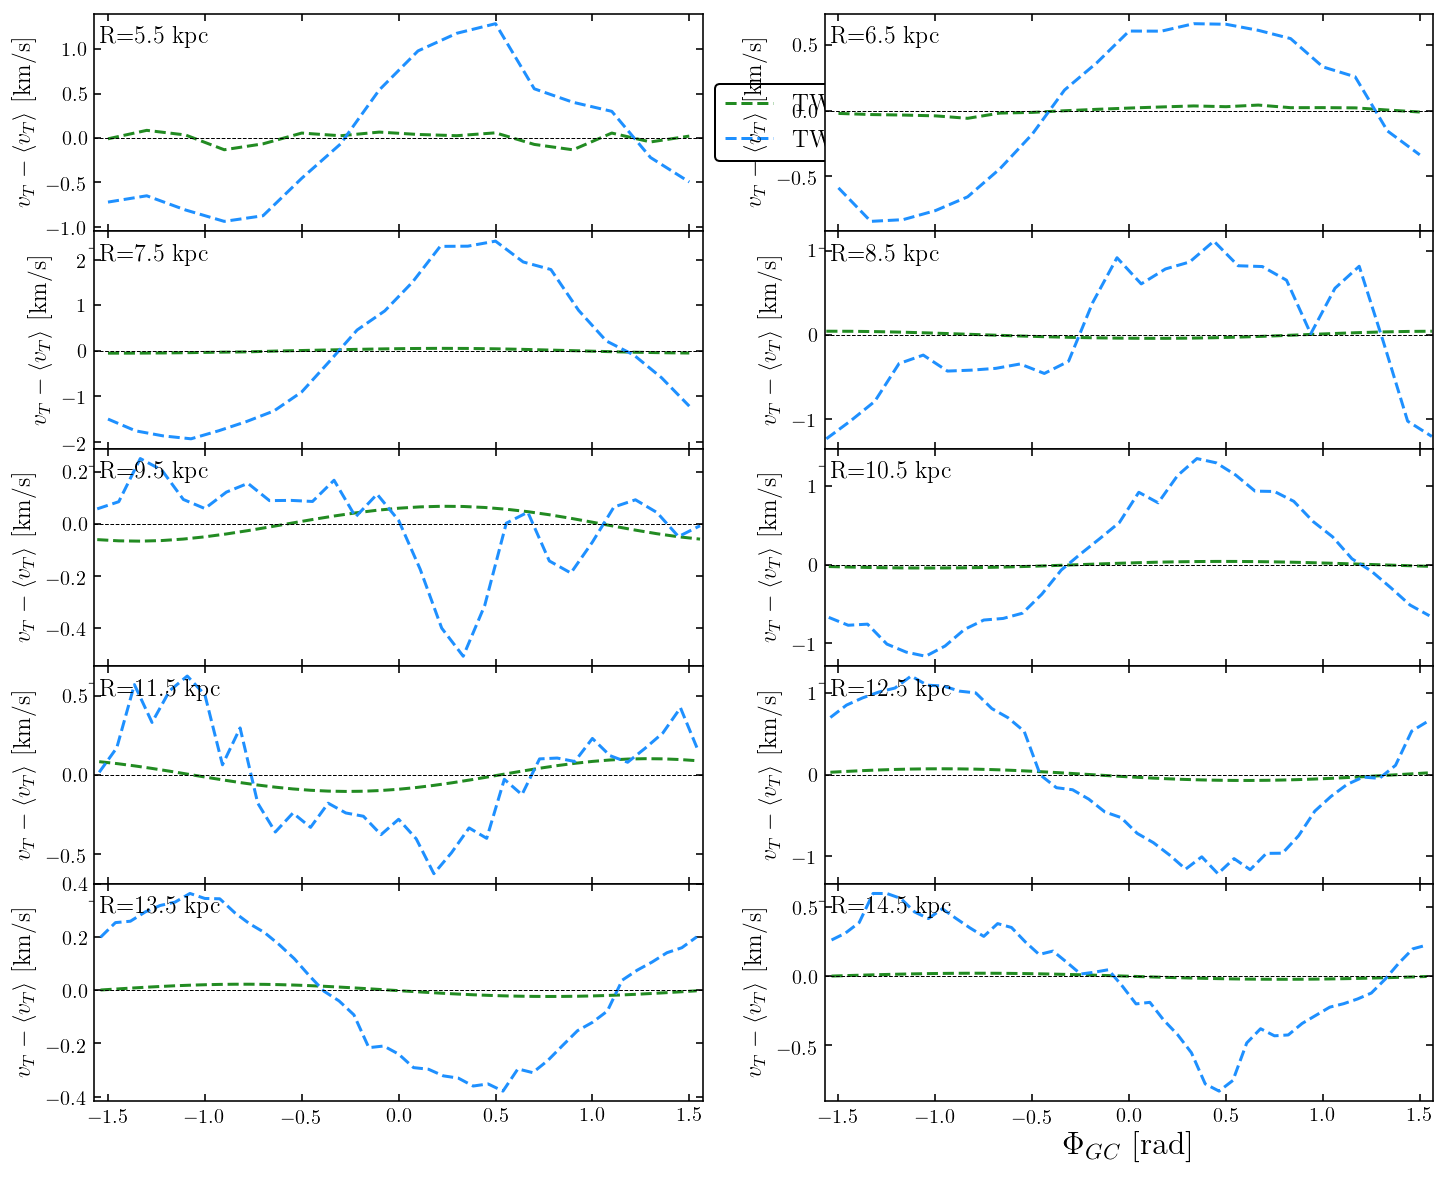

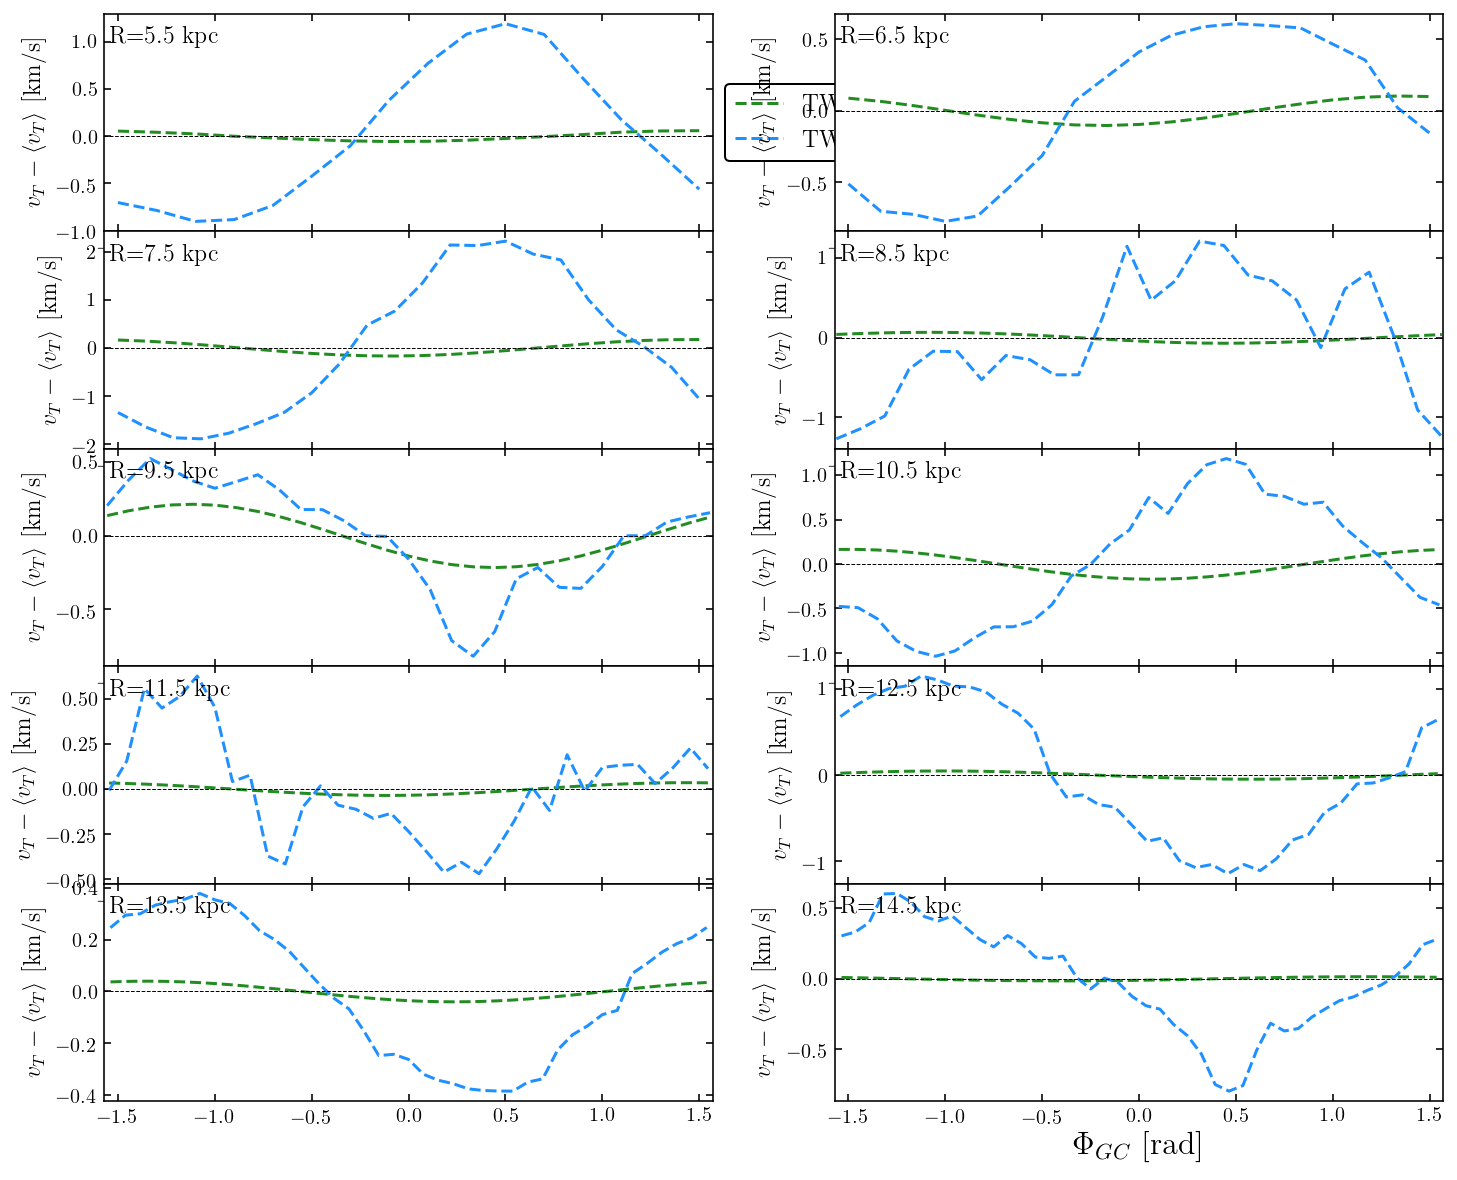

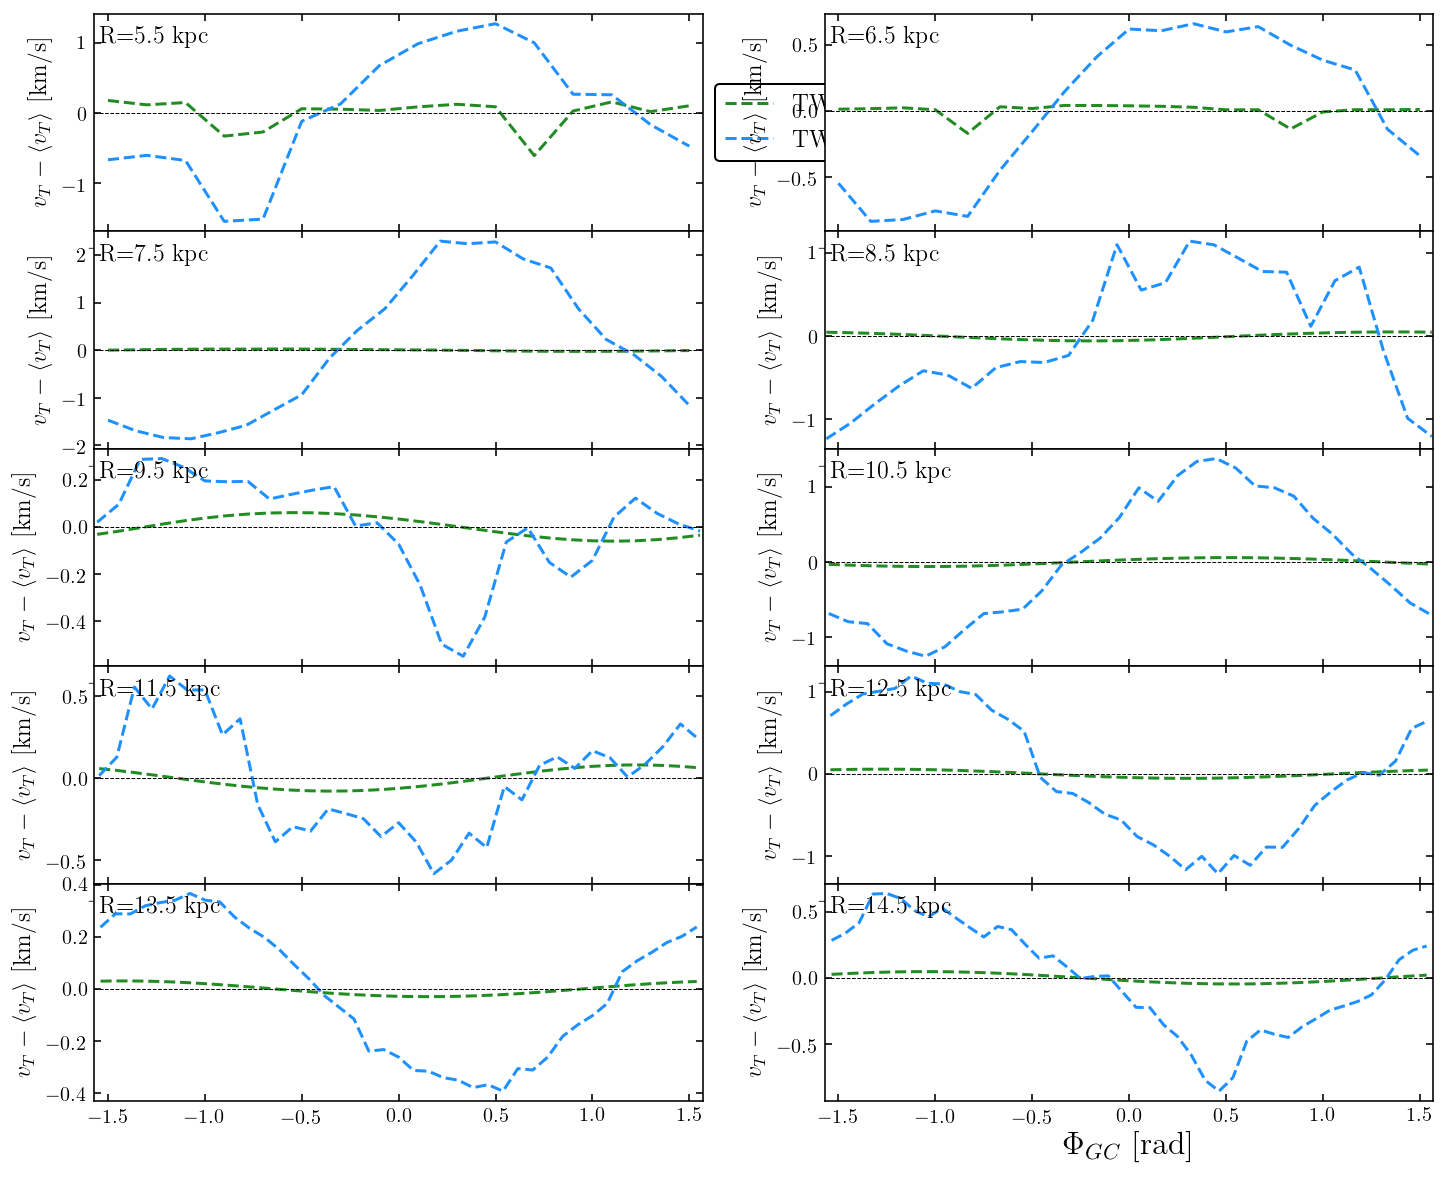

In [20]:
vel_ind = 6 # Index for tangential velocity

# Now loop over each b value
for i in range( n_files ):
    
    # Make the figure. 4 columns of axes, one for each radial bin.
    fig = plt.figure( figsize=(12,int(n_R) ) )
    axs = fig.subplots( nrows=int(n_R/2), ncols=2 ).reshape(n_R)
    
    # Load the data
    tws_data = np.load( tws_filenames[i] ).astype(float)
    tws_lsbar_data = np.load( tws_bar_filenames[i] ).astype(float)
    
    # Loop over each radial bin
    for j in range( n_R ):
        
        # Load data
        where_current_R_tws = np.where( tws_data[:,0] == R_range[j] )[0]
        where_current_R_tws_lsbar = np.where( tws_lsbar_data[:,0] == R_range[j] )[0]
        
        # Get the velocity and angle
        tws_v = tws_data[ where_current_R_tws, vel_ind ]
        tws_v -= np.mean(tws_v)
        tws_phi = tws_data[ where_current_R_tws, 1 ]
        tws_lsbar_v = tws_lsbar_data[ where_current_R_tws_lsbar, vel_ind ]
        tws_lsbar_v -= np.mean(tws_lsbar_v)
        tws_lsbar_phi = tws_lsbar_data[ where_current_R_tws_lsbar, 1 ]
        
        # Plot the data
        axs[j].plot(tws_phi, tws_v, color='ForestGreen', linestyle='dashed',
                         label=labels[0])
        axs[j].plot(tws_lsbar_phi, tws_lsbar_v, color='DodgerBlue', linestyle='dashed', 
                         label=labels[1])
        
        # Decorate
        axs[j].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
        axs[j].set_xlim(-np.pi/2,np.pi/2)
        
        axs[j].annotate(r'R='+str(R_range[j])+' kpc', (0.01,0.86), xycoords='axes fraction', fontsize=12)
        axs[j].set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$ [km/s]', fontsize=12)
        
        if j!=int((n_R/2)-1) or j!=int(n_R-1):
            axs[j].tick_params(labelbottom='off')
        ##fi
        
    ###j
    
    # Final decorate
    axs[0].legend(loc='center left', bbox_to_anchor=(1.0,0.5), fontsize=12)
    axs[-1].set_xlabel(r'$\Phi_{GC}$ [rad]', fontsize=16)
    axs[int(-1+n_R/2)].set_xlabel(r'$\Phi_{GC}$ [rad]', fontsize=16)
    fig.subplots_adjust(hspace=0)
    fig.set_facecolor('white')
###i

fig.subplots_adjust(hspace=0)
plt.savefig('tws_vT.png')
plt.show()
pass;

# Plot radial velocity

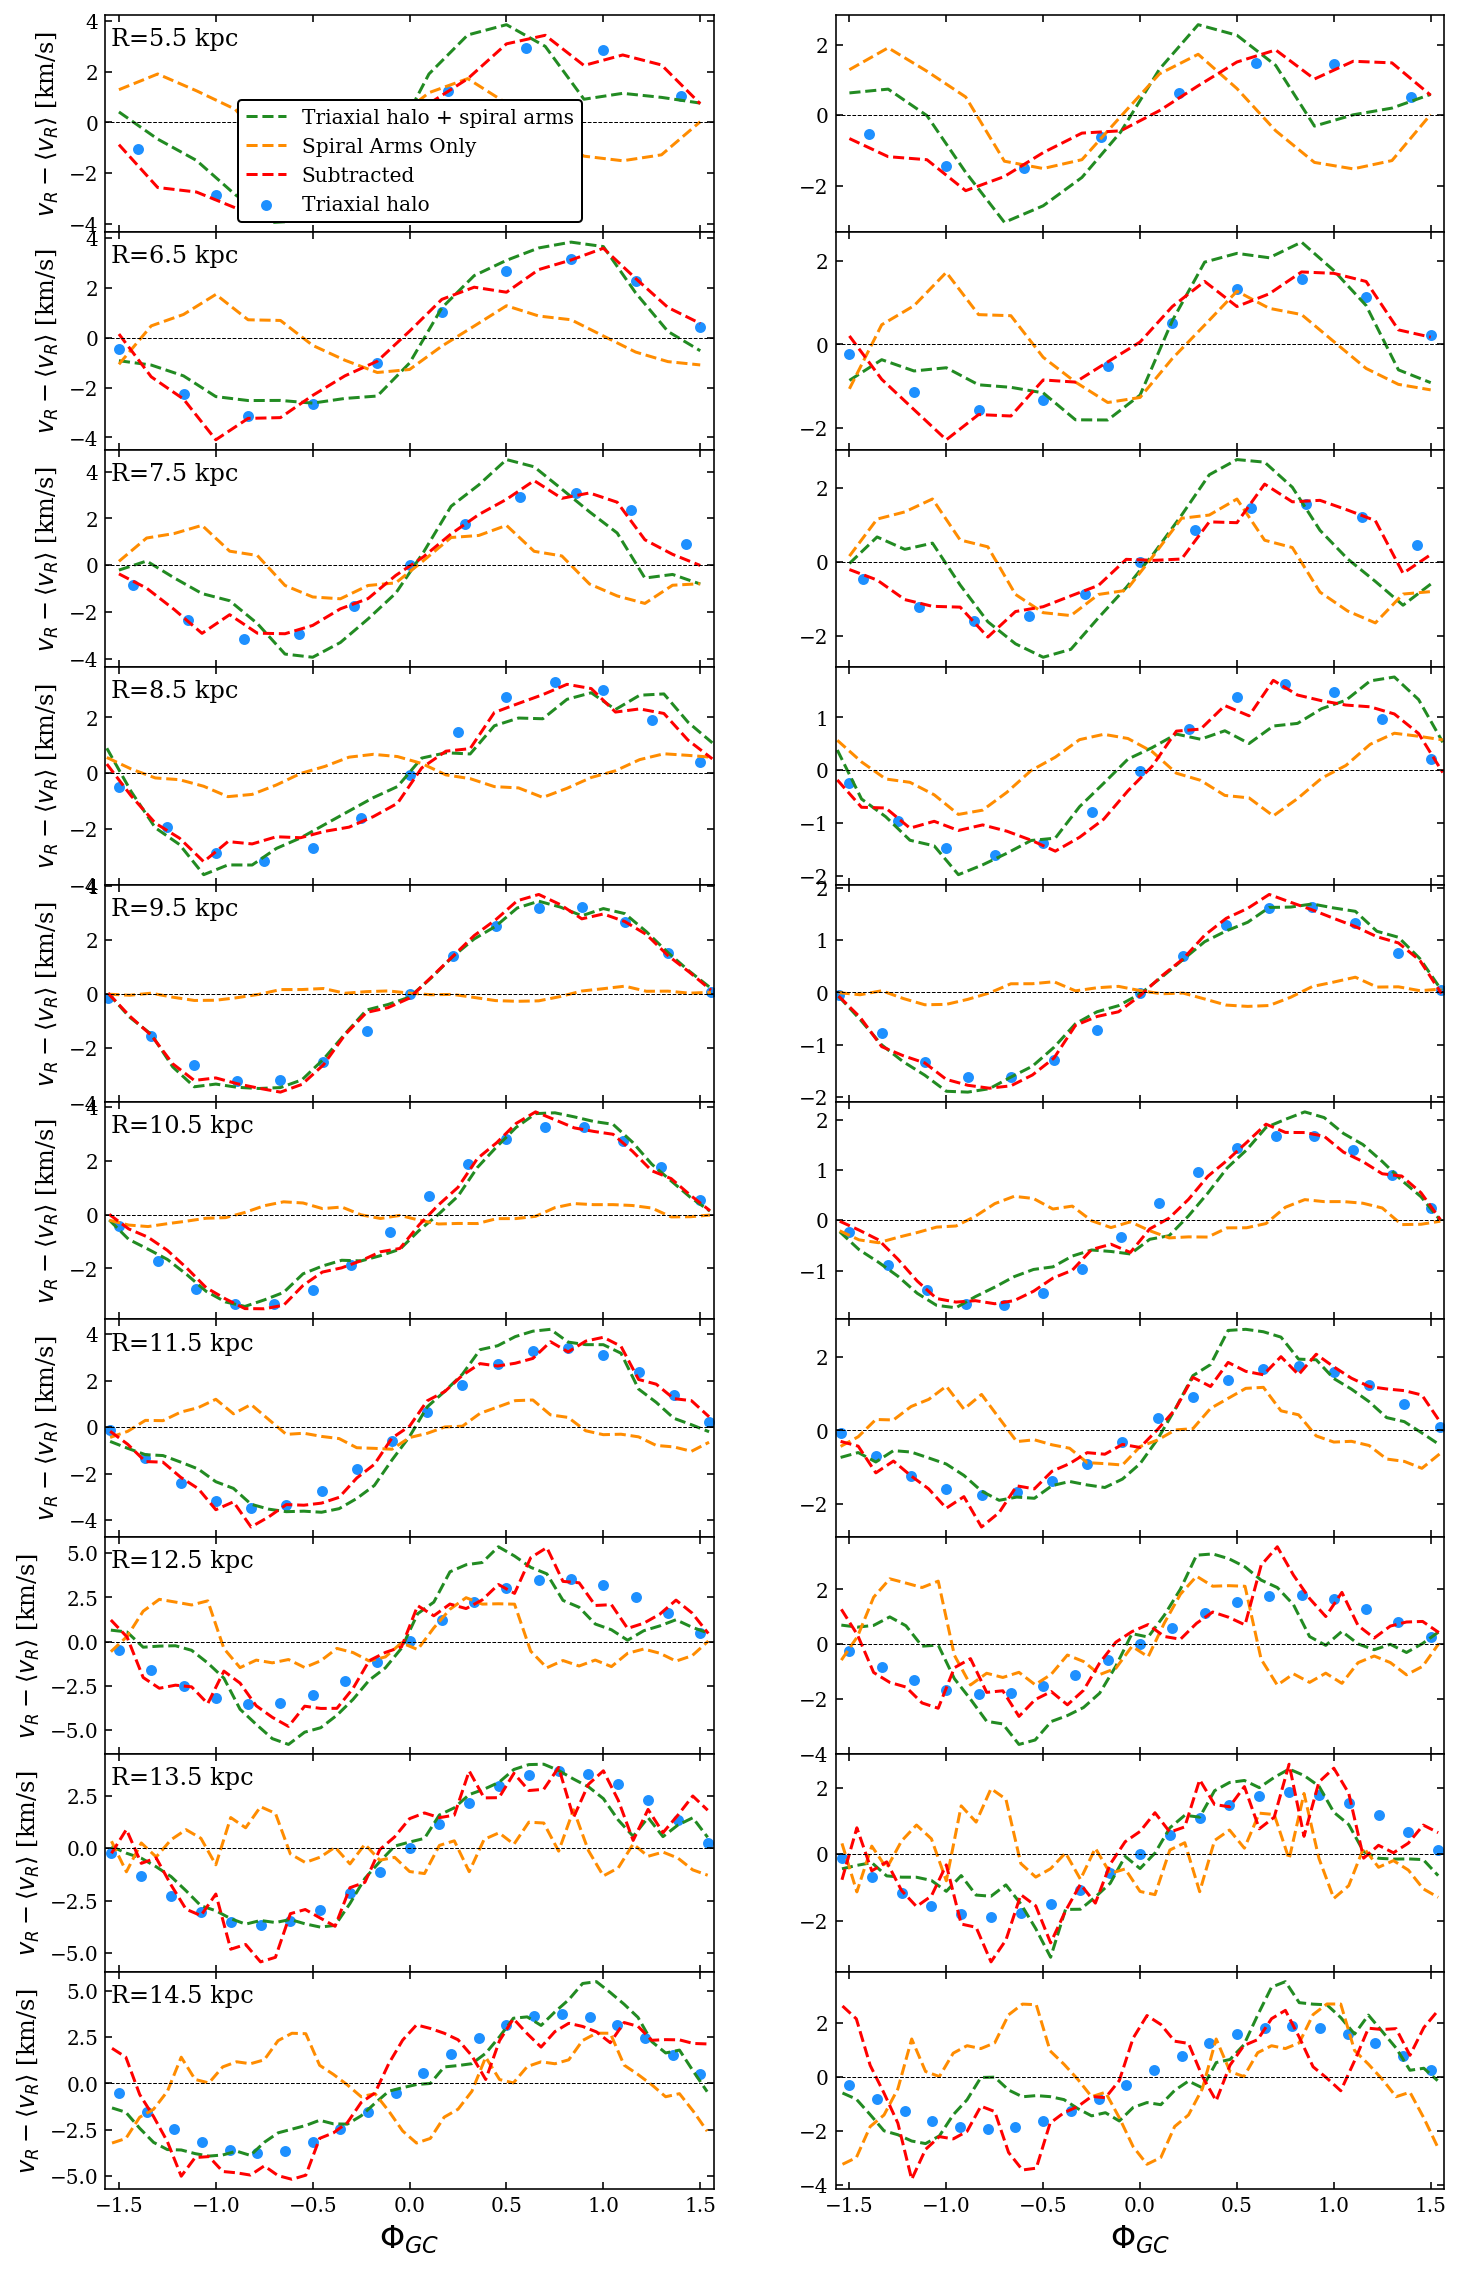

In [16]:
# Make the figure. 4 columns of axes, one for each radial bin.
fig = plt.figure( figsize=(12,int(n_R*2) ) )
axs = fig.subplots( nrows=n_R, ncols=2 )

# Read in just the spiral data


# Now loop over each b value
for i in range( n_files ):
    
    # Load the data
    sim_pert_data = np.load( pert_files[i] ).astype(float)
    sim_halo_data = np.load( trihalo_files[i] ).astype(float)
    
    # Loop over each radial bin
    for j in range( n_R ):
        
        # Load data
        where_current_R_spiral = np.where( sim_pert_data[:,0] == R_range[j] )[0]
        where_current_R_halo = np.where( sim_halo_data[:,0] == R_range[j] )[0]
        
        # Get the velocity and angle
        sim_pert_v = sim_pert_data[ where_current_R_spiral, 4 ]
        sim_pert_v -= np.mean(sim_pert_v)
        sim_pert_phi = sim_pert_data[ where_current_R_spiral, 1 ]
        sim_halo_v = sim_halo_data[ where_current_R_halo, 4 ]
        sim_halo_v -= np.mean(sim_halo_v)
        sim_halo_phi = sim_halo_data[ where_current_R_halo, 1 ]
        
        # Plot the data
        axs[j,i].plot(sim_pert_phi, sim_pert_v, color='ForestGreen', 
                         label=pert_label, linestyle='dashed')
        axs[j,i].scatter(sim_halo_phi, sim_halo_v, color='DodgerBlue', marker='o', 
                         label=trihalo_label, s=20)
        
        # Load spiral only data
        where_current_R_pert_only = np.where( sim_pert_only_data[:,0] == R_range[j] )[0]
        if len(where_current_R_pert_only) > 0:
            sim_pert_only_v = sim_pert_only_data[ where_current_R_pert_only, 4 ]
            sim_pert_only_v -= np.mean(sim_pert_only_v)
            sim_pert_only_phi = sim_pert_only_data[ where_current_R_pert_only, 1 ]
            axs[j,i].plot(sim_pert_only_phi, sim_pert_only_v, color='DarkOrange', 
                             label='Spiral Arms Only', linestyle='dashed')
            
            # Take the difference between the triaxial halo + spiral and triaxial halo
            axs[j,i].plot(sim_pert_only_phi, sim_pert_v-sim_pert_only_v, 
                          color='Red', linestyle='dashed', label='Subtracted' )
        ##fi
            
            
        # Decorate
        axs[j,i].axhline(0, linestyle='dashed', color='Black', linewidth=0.5)
        axs[j,i].set_xlim(-np.pi/2,np.pi/2)
        
        if i == 0:
            axs[j,i].annotate(r'R='+str(R_range[j])+' kpc', (0.01,0.86), xycoords='axes fraction', fontsize=12)
            axs[j,i].set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$ [km/s]', fontsize=12)
        ##fi
        
        if j < n_R-1:
            axs[j,i].tick_params(labelbottom='off')
        ##fi
    ###j
    
    # Final decorate
    if i == 0:
        axs[0,i].legend(loc='lower center')
    
    axs[-1,i].set_xlabel(r'$\Phi_{GC}$', fontsize=16)
    fig.subplots_adjust(hspace=0)

###i

fig.subplots_adjust(hspace=0)

plt.show()
pass;